
# Подгружаем все необходимые библиотеки и функции

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import tensorflow.compat.v1 as tf
from keras.models import Model, load_model
from keras import backend as K
from keras.callbacks import ModelCheckpoint

from keras.optimizers import Adam
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, BatchNormalization, Add, Conv2DTranspose, Reshape
from keras.layers.core import Activation
from keras.losses import binary_crossentropy

import numpy as np
import matplotlib.pyplot as plt

import os
import sys
from PIL import Image
from skimage.io import imsave
from tqdm import tqdm, tqdm_notebook

sys.path.append('./drive/My Drive/Rosneft Seismic/models/modules')

from load_data_2 import load_data
from uresnet_v3 import uresnet3

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Using TensorFlow backend.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Инициализируем константы

In [0]:
K.set_image_data_format('channels_last')                # Формат последнего канала

LAYER = '0'                                             # Номер слоя земли
VERSION = 3                                             # Версия самбита
EPOCHS = 20                                             # Количество эпох обучения (чтобы укладывалось в 12 часов)
BATCH_SIZE = 4                                          # Размер батча обучения (максимально позволительное GPU)
VERBOSE = 1                                             # Подробности обучения
OPTIMIZER = Adam(lr=3e-5)                               # Оптимизатор 
IMG_ROWS, IMG_COLS, IMG_CHANNELS = 384, 384, 1          # Размеры используемых моделью изображений
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, IMG_CHANNELS)
FILEPATH = 'drive/My Drive/Rosneft Seismic/models/weight/weights_layer_'+LAYER+'_v'+str(VERSION)+'.h5' # Путь к модели

# Загружаем тренировочную и валидационную выборку слоя *LAYER*

In [3]:
x_valid, y_valid = load_data(LAYER, val=True)
x_train, y_train = load_data(LAYER, val=False)

LOAD VALIDATION DATA
--load inline images



--load xline images



END LOAD VALIDATION DATA
STAR PREPROCCECING
END PREPROCCECING
LOAD TRAIN DATA
--load inline images



--load xline images



END LOAD TRAIN DATA
STAR PREPROCCECING
END PREPROCCECING


In [4]:
print(x_train.shape)
print(x_valid.shape)

print(y_train.shape)
print(y_valid.shape)

(3072, 384, 384, 1)
(256, 384, 384, 1)
(3072, 384, 384, 2, 1)
(256, 384, 384, 2, 1)


# Определяем модель и лосс

In [0]:
def dice(y_true, y_pred):
    y_true_f = K.flatten(y_true[:,:,:,0])
    y_pred_f = K.flatten(y_pred[:,:,:,0])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 0.001) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.001)

def dice_border(y_true, y_pred):
    y_true_f = K.flatten(y_true[:,:,:,0] * y_true[:,:,:,1])
    y_pred_f = K.flatten(y_pred[:,:,:,0] * y_true[:,:,:,1])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 0.001) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.001)

def dice_coef(y_true, y_pred):
    return (dice(y_true, y_pred) + dice_border(y_true, y_pred)) / 2.0

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# Функция потерь для минимизации
def bce_dice_coef_loss(y_true, y_pred): 
    print(y_true.shape)
    print(y_pred.shape)
    return 0.25 * dice_coef_loss(y_true[:,:,:,:,0], y_pred[:,:,:,:,0]) + 0.75 * binary_crossentropy(y_true[:,:,:,0,0], y_pred[:,:,:,0,0])

In [0]:
def uresnet2(image_rows, image_cols, img_channels=1, optimizer=Adam(lr=3e-4)):

  def batch_block(activation=True):
    def f(x):
      batch_norm = BatchNormalization()(x)
      if activation:
        batch_norm = Activation(activation='relu')(batch_norm)
      return batch_norm
    return f

  def conv_block(filters_num):
    def f(x):
      batch = batch_block()(x)
      conv = Conv2D(filters_num, (3, 3), padding='same')(batch)
      return conv
    return f

  def conv_block_transp(filters_num):
    def f(x):
      batch = batch_block()(x)
      conv = Conv2DTranspose(filters_num, (3, 3), padding='same')(batch)
      return conv
    return f

  def stem(filters_num):
    def f(x):
      conv = Conv2D(filters_num, (3, 3), padding='same')(x)
      conv = conv_block(filters_num)(conv)
      shortcut = Conv2D(filters_num, (3, 3), padding='same')(x)
      shortcut = batch_block(False)(shortcut)
      return Add()([conv, shortcut])
    return f

  def residual_block(filters_num):
    def f(x):
      conv = conv_block(filters_num)(x)
      conv = conv_block(filters_num)(conv)
      shortcut = Conv2D(filters_num, (3, 3), padding='same')(x)
      shortcut = batch_block(False)(shortcut)
      return Add()([conv, shortcut])
    return f

  def residual_block_transp(filters_num):
    def f(x):
      conv = conv_block_transp(filters_num)(x)
      conv = conv_block(filters_num)(conv)
      shortcut = Conv2D(filters_num, (3, 3), padding='same')(x)
      shortcut = batch_block(False)(shortcut)
      return Add()([conv, shortcut])
    return f

  filters = [32, 64, 128, 256, 512]
  # ROOT
  inputs = Input((image_rows, image_cols, img_channels))
  root = stem(filters[0])(inputs)

  # ENCODER
  res1 = residual_block(filters[0])(root)
  pool1 = MaxPooling2D(pool_size=(2, 2))(res1)

  res2 = residual_block(filters[1])(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(res2)

  res3 = residual_block(filters[2])(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(res3)

  res4 = residual_block(filters[3])(pool3)
  pool4 = MaxPooling2D(pool_size=(2, 2))(res4)

  # BRIDGE
  res5 = residual_block(filters[4])(pool4)
  res5 = residual_block(filters[4])(res5)

  # DECODER
  up1 = concatenate([UpSampling2D(size=(2, 2))(res5), res4], axis=3)
  resT1 = residual_block_transp(filters[3])(up1)

  up2 = concatenate([UpSampling2D(size=(2, 2))(resT1), res3], axis=3)
  resT2 = residual_block_transp(filters[2])(up2)

  up3 = concatenate([UpSampling2D(size=(2, 2))(resT2), res2], axis=3)
  resT3 = residual_block_transp(filters[1])(up3)

  up4 = concatenate([UpSampling2D(size=(2, 2))(resT3), res1], axis=3)
  resT4 = residual_block_transp(filters[0])(up4)

  # OUTPUT
  out = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(resT4)
  outputs = Reshape((384, 384, 2, 1))(concatenate([out, out], axis=3))

  return Model(inputs=[inputs], outputs=[outputs])

# Запускаем обучение сети

In [7]:
model = uresnet2(IMG_ROWS, IMG_COLS, IMG_CHANNELS, OPTIMIZER)
model.compile(optimizer=OPTIMIZER, loss=bce_dice_coef_loss, metrics=[dice_coef])
model.summary()

model_checkpoint = ModelCheckpoint(filepath=FILEPATH, monitor='val_loss', save_best_only=True)















(?, ?, ?, ?, ?)
(?, 384, 384, 2, 1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 384, 384, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 384, 384, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 384, 384, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 384, 38

In [0]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE,
                    shuffle=True, validation_data=(x_valid, y_valid), callbacks=[model_checkpoint])



Train on 3072 samples, validate on 256 samples
Epoch 1/20
3072/3072 [==============================] - 823s 268ms/step - loss: 0.0704 - dice_coef: 0.8784 - val_loss: 0.0217 - val_dice_coef: 0.9529
Epoch 2/20
3072/3072 [==============================] - 808s 263ms/step - loss: 0.0094 - dice_coef: 0.9785 - val_loss: 0.0194 - val_dice_coef: 0.9721
Epoch 3/20
3072/3072 [==============================] - 810s 264ms/step - loss: 0.0060 - dice_coef: 0.9862 - val_loss: 0.0137 - val_dice_coef: 0.9735
Epoch 4/20
3072/3072 [==============================] - 809s 263ms/step - loss: 0.0046 - dice_coef: 0.9895 - val_loss: 0.0134 - val_dice_coef: 0.9767
Epoch 5/20
3072/3072 [==============================] - 810s 264ms/step - loss: 0.0038 - dice_coef: 0.9915 - val_loss: 0.0131 - val_dice_coef: 0.9779
Epoch 6/20
3072/3072 [==============================] - 807s 263ms/step - loss: 0.0030 - dice_coef: 0.9931 - val_loss: 0.0128 - val_dice_coef: 0.9796
Epoch 7/20
3072/3072 [=============================

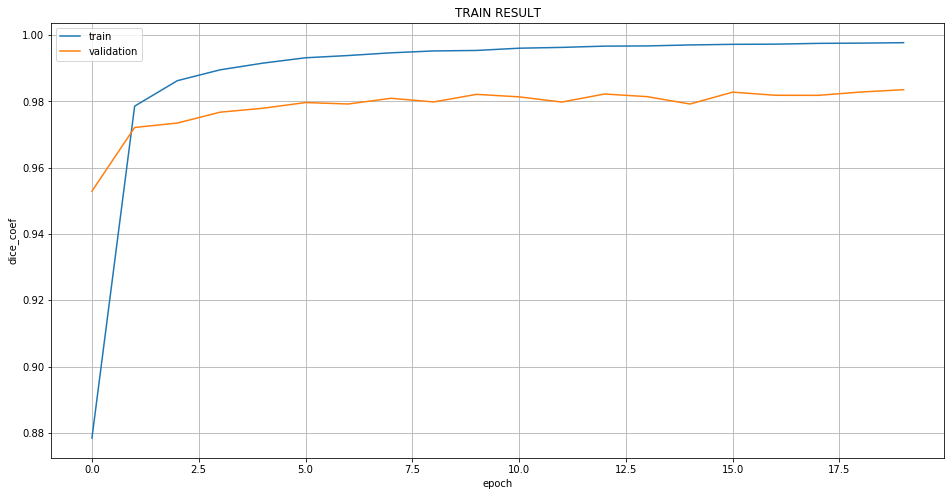

In [0]:
plt.figure(figsize=(16, 8))
plt.plot(history.history['dice_coef'], "o-", label="train")
plt.plot(history.history['val_dice_coef'], "s-", label="validation")
plt.title('TRAIN RESULT')
plt.ylabel('dice_coef')
plt.xlabel('epoch num')
plt.legend(loc='best', framealpha=0.75)
plt.grid()
plt.show()

In [0]:
plt.plot(history.history['bce_dice_coef_loss'])
plt.plot(history.history['val_bce_dice_coef_loss'])
plt.title('MODEL LOSS')
plt.ylabel('bce_dice_coef_loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.grid()
plt.show()


NameError: ignored

## Дополнительные эпохи для дообучения


In [0]:
ADD_EPOCHS = 3

model = load_model(FILEPATH, custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=ADD_EPOCHS, verbose=VERBOSE, 
                    shuffle=True, validation_split=VALIDATION_SPLIT, callbacks=[model_checkpoint])


plt.figure(figsize=(16, 8))
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('TRAIN RESULT')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.grid()
plt.show()

# **Загружаем модель слоя LAYER**
 **Подбираем соответвующий treshold**


In [12]:
model2 = load_model(FILEPATH, custom_objects={'bce_dice_coef_loss': bce_dice_coef_loss, 'dice_coef': dice_coef})

(?, ?, ?, ?, ?)
(?, 384, 384, 2, 1)




In [13]:
y_pred = model.predict(x_valid, verbose=1)

256/256 [==============================] - 12s 47ms/step


In [15]:
y_valid.shape

(256, 384, 384, 2, 1)

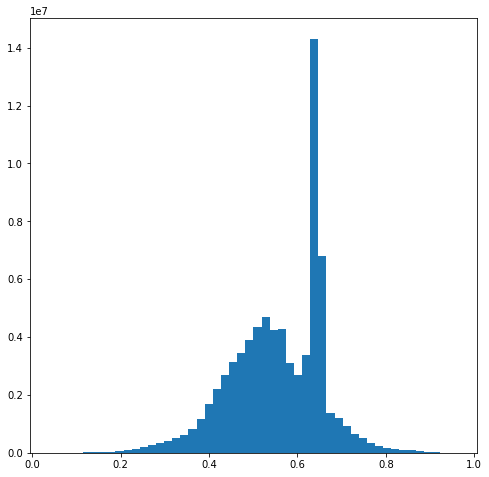

In [29]:
plt.figure(figsize=(8, 8))
plt.hist(y_pred.flatten(), bins=50)
plt.show()

In [0]:
def find_threshold(y_true, y_pred_soft):

    def dice_local(y_true, y_pred):
        y_true_f = y_true[:,:,0].flatten()
        y_pred_f = y_pred[:,:,0].flatten()
        return (2.0 * np.sum(y_true_f * y_pred_f) + 0.001) / (np.sum(y_true_f) + np.sum(y_pred_f) + 0.001)

    def dice_border_local(y_true, y_pred):
        y_true_f = (y_true[:,:,0] * y_true[:,:,1]).flatten()
        y_pred_f = (y_pred[:,:,0] * y_true[:,:,1]).flatten()
        return (2.0 * np.sum(y_true_f * y_pred_f) + 0.001) / (np.sum(y_true_f) + np.sum(y_pred_f) + 0.001)

    def dice_coef_local(y_true, y_pred):
        return (dice_local(y_true, y_pred) + dice_border_local(y_true, y_pred)) / 2.0

    thresholds = np.linspace(0.01, 0.99, 99)
    thrs_dice_coefs = []
    SAMPLES = y_true.shape[0]

    for threshold in tqdm_notebook(thresholds):
        y_pred_hard = np.where(y_pred_soft < threshold, 0., 1.).astype('float32')
        dice_coefs = np.array([
            dice_coef_local(y_true[i,:,:,:,0], y_pred_hard[i,:,:,:,0]) for i in range(SAMPLES)
        ])
        thrs_dice_coefs.append((threshold, dice_coefs.mean()))
    thrs_dice_coefs = sorted(thrs_dice_coefs, key=lambda x: x[1], reverse=True)
    return thrs_dice_coefs[0][0], thrs_dice_coefs

In [19]:
threshold, thrs = find_threshold(y_valid, y_pred)

In [26]:
thrs

[(0.35000000000000003, 0.5594293418968438),
 (0.34, 0.5593767436836741),
 (0.36000000000000004, 0.5593113424985305),
 (0.33, 0.5593080416584107),
 (0.32, 0.5592618042700026),
 (0.31, 0.5592470067734977),
 (0.27, 0.559228141613495),
 (0.26, 0.5592045751042134),
 (0.3, 0.5591917813558089),
 (0.28, 0.5591638893820746),
 (0.29000000000000004, 0.5591395047695424),
 (0.25, 0.5591390893473523),
 (0.24000000000000002, 0.5590767642408108),
 (0.23, 0.5590274851687176),
 (0.22, 0.5589881180937436),
 (0.21000000000000002, 0.5589562626193745),
 (0.2, 0.558930619229355),
 (0.19, 0.5589093741154139),
 (0.18000000000000002, 0.5588914339721112),
 (0.17, 0.5588762893196891),
 (0.16, 0.5588636451456941),
 (0.15000000000000002, 0.5588533726174859),
 (0.14, 0.5588449186550875),
 (0.13, 0.5588381145447034),
 (0.12, 0.5588328045332864),
 (0.11, 0.5588288807424981),
 (0.09999999999999999, 0.5588261818673894),
 (0.09, 0.5588241580983141),
 (0.08, 0.5588228508894875),
 (0.06999999999999999, 0.5588219206420175),

(array([35.,  0.,  0.,  0.,  6.,  5.,  2.,  2.,  3., 46.]),
 array([3.74431959e-07, 5.59432712e-02, 1.11886168e-01, 1.67829065e-01,
        2.23771961e-01, 2.79714858e-01, 3.35657755e-01, 3.91600652e-01,
        4.47543548e-01, 5.03486445e-01, 5.59429342e-01]),
 <a list of 10 Patch objects>)

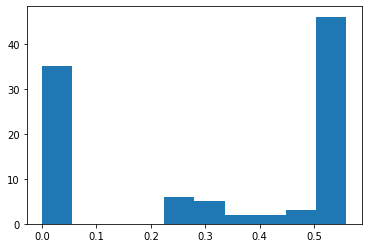

In [25]:
plt.hist(np.array([thr[1] for thr in thrs]))

  0%|          | 0/412 [00:00<?, ?it/s]

LOAD TRAIN DATA
--load inline images


  0%|          | 0/306 [00:00<?, ?it/s]

--end load inline images
--load xline images


  0%|          | 0/412 [00:00<?, ?it/s]

--end load xline images
--load turn inline images


  0%|          | 0/306 [00:00<?, ?it/s]

--end load turn inline images
--load turn xline images


100%|██████████| 306/306 [03:58<00:00,  1.38it/s]


--end load turn xline images
END LOAD TRAIN DATA
STAR PREPROCCECING


  0%|          | 0/50 [00:00<?, ?it/s]

END PREPROCCECING
LOAD VALIDATION DATA
--load inline images


  0%|          | 0/39 [00:00<?, ?it/s]

--end load inline images
--load xline images


  0%|          | 0/50 [00:00<?, ?it/s]

--end load xline images
--load turn inline images


  0%|          | 0/39 [00:00<?, ?it/s]

--end load turn inline images
--load turn xline images


  0%|          | 0/51 [00:00<?, ?it/s]

--end load turn xline images
--load sinus inline images


100%|██████████| 51/51 [00:45<00:00,  1.22it/s]


--end load sinus inline images
END LOAD VALIDATION DATA
STAR PREPROCCECING
END PREPROCCECING
2611/2611 [==============================] - 276s 106ms/step


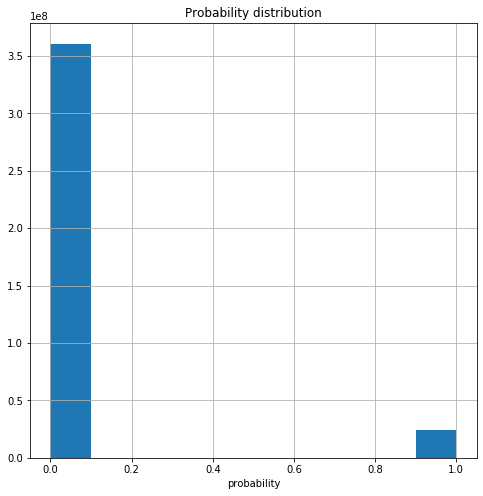

100%|██████████| 99/99 [12:09<00:00,  5.89s/it]

0.14


In [0]:
model = load_model(FILEPATH, custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})

x_full_1, y_full_1 = load_train(LAYER)
x_full_2, y_full_2 = load_valid(LAYER)
x_full = np.concatenate((x_full_1, x_full_2), axis = 0)
y_full = np.concatenate((y_full_1, y_full_2), axis = 0)
y_pred = model.predict(x_full, verbose=1)

plt.figure(figsize=(8, 8))
plt.hist(y_pred.flatten())
plt.title('Probability distribution')
plt.xlabel('probability')
plt.grid()
plt.show()

threshold = find_threshold(y_full, y_pred)
print(threshold)

# **Загружаем тестовую выборку слоя LAYER**

In [0]:
test_name, x_test = load_test()

100%|██████████| 2751/2751 [13:27<00:00,  2.73it/s]


# **Запускаем модель на тестовой выборке**

In [0]:
test_path = 'drive/My Drive/Rosneft Seismic/test/answer/' + LAYER + '/'
for name, image in tqdm(zip(test_name, x_test)):
  image = list(image)
  size, cut_image = cut_test_img(image)

  predict = model.predict(cut_image, verbose=0)

  y_test = connect_test_img(size, predict)
  y_test = np.where(y_test < threshold, 0, 255)
  y_test = y_test.astype(np.uint8)

  imsave(test_path+name, y_test)


2751it [24:36,  1.81it/s]
